# Visualization of clustered structures

In [28]:
import numpy as np
import time
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import random
from ase.io import read, write
from tqdm import tqdm
from ase.visualize import view

In [2]:
sys.path.append('../../')
from src import myTools, plotTools

In [3]:
def print_labels_pop(labels_):
    for v in np.unique(labels_):
        if v == -1:
            mask = labels_ == v
            print(f"Noise clusters: {len(labels_[mask])}")
        if v > -1:
            mask = labels_ == v
            print(f"Clust:{v} - counts: {np.bincount(labels_[mask])[-1]}")

In [4]:
def get_idx_to_labels(labels):
    idx_to_labels_dict = dict()
    for c in np.unique(labels):
        idx_tmp_list = list()
        for idx,lab in enumerate(labels):
            if lab == c:
                idx_tmp_list.append(idx)
        idx_to_labels_dict[str(c)] = idx_tmp_list
    print_labels_pop(labels_=labels)
    return idx_to_labels_dict

In [5]:
def get_random_choices(idx_dict,nc=1):
    structure_idx_selection_dict = dict()
    for cl,idx in idx_dict.items():
        if int(cl) >= 0:
            choice_ = random.choices(idx,k=nc)
            structure_idx_selection_dict[cl] = choice_
        # print(cl, choice_)
    return structure_idx_selection_dict

## $\ell$-PCA HDBSCAN clusters

In [6]:
X = np.load('./dimred_data/lpca9_n_Z1_Z3_Nframe5000.npy')
X.shape

(5000, 9)

In [7]:
labels = np.loadtxt('soap_lpca_hdbscan.labels').astype(int)
len(labels), labels

(5000, array([ 3,  3,  3, ...,  6,  6, -1]))

In [8]:
hdbscan_idx_dict = get_idx_to_labels(labels=labels)

Noise clusters: 836
Clust:0 - counts: 32
Clust:1 - counts: 39
Clust:2 - counts: 455
Clust:3 - counts: 2070
Clust:4 - counts: 40
Clust:5 - counts: 137
Clust:6 - counts: 1391


In [9]:
len(hdbscan_idx_dict['1'])

39

In [10]:
structure_selection_dict = get_random_choices(hdbscan_idx_dict, nc=2)

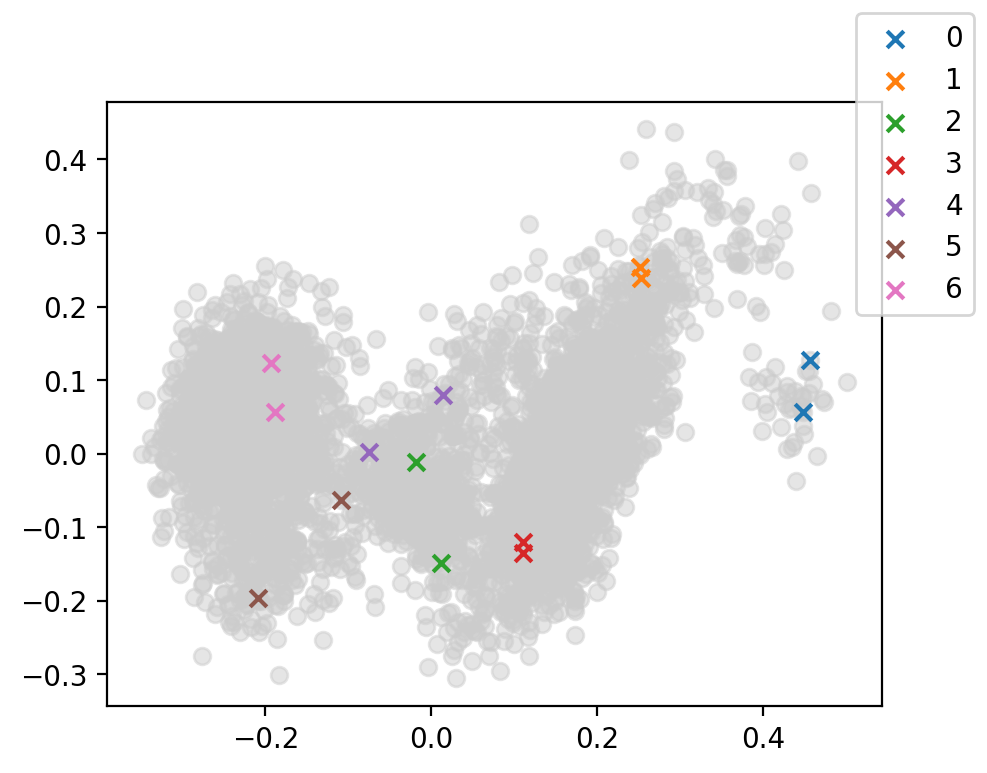

In [42]:
fig, ax = plotTools.get_axes(1)

ax.scatter(X[:,0], X[:,1], c='0.8', alpha=0.5, zorder=1)
for cl,cho in structure_selection_dict.items():
    if int(cl) >= 0:
        ax.scatter(X[cho,0], X[cho,1], marker='x', label=cl, zorder=2)
fig.legend()

In [12]:
structure_selection_dict

{'0': [3104, 3118],
 '1': [3718, 3738],
 '2': [2935, 1324],
 '3': [4464, 4469],
 '4': [164, 1470],
 '5': [3153, 1509],
 '6': [4637, 4613]}

### Traj viewer

In [13]:
traj = '/home/agardin/workPHD/1.cambridge/MLanalysis/proDOT/0.data/ProDOT-2Hex-00PC-cryst.xyz'

In [40]:
def get_cluster_structures(traj, structure_sel_dict, 
                           ref_atom_symbol='Li', cutoff=6.0):
    # - loop on the clusters and specific indeces
    for cluster, index in structure_sel_dict.items():
        print(f"Analyzing Cluster: {cluster} .. {index}")
        
        # - loop over the specific indeces
        for idx in index:
            # select the frame choosen
            frame = read(traj, index=f'{idx}:{idx+1}')[0]
            # get the ref atom position
            ref_atom_pos = frame[frame.symbols==ref_atom_symbol].get_positions()
            
            # - get info inside the cutoff index
            in_cutoff_ndx = list()
            for i,_ in enumerate(frame):
                if np.linalg.norm(frame.get_positions()[i]-ref_atom_pos) <= 6.:
                    in_cutoff_ndx.append(i)
            
            in_cutoff_atoms = frame[in_cutoff_ndx]
            # - output traj files unscaled
            write(f'full_traj_frame{idx}.xyz', frame)
            write(f'cluster{cluster}_frame{idx}_unscaled.xyz', in_cutoff_atoms)
            
            # --- scaled positions and remove box
            in_cutoff_atoms.set_positions(
                in_cutoff_atoms.get_positions() - ref_atom_pos
            )
            in_cutoff_atoms.set_cell([[0,0,0],[0,0,0],[0,0,0]])
            # - output scaled traj and images
            write(f'cluster{cluster}_frame{idx}_scaled.xyz', in_cutoff_atoms)
            write(f'cluster{cluster}_frame{idx}.png', in_cutoff_atoms)

In [41]:
get_cluster_structures(traj=traj, 
                       structure_sel_dict=structure_selection_dict)

Analyzing Cluster: 0 .. [3104, 3118]
Analyzing Cluster: 1 .. [3718, 3738]
Analyzing Cluster: 2 .. [2935, 1324]
Analyzing Cluster: 3 .. [4464, 4469]
Analyzing Cluster: 4 .. [164, 1470]
Analyzing Cluster: 5 .. [3153, 1509]
Analyzing Cluster: 6 .. [4637, 4613]
